<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/04_Transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned pattern for our own data.

The two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data,

In [20]:
#Are we using a GPU?
!nvidia-smi

Sat Feb 19 09:05:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    40W /  70W |   8946MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download and becoming one with the data

In [2]:
#Get data (10% of 10 food classes from Food101)
import zipfile

#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-19 09:01:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  88.2MB/s    in 1.8s    

2022-02-19 09:01:34 (88.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
#how many images in each folder
import os

#walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")


There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/train'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'. 
There are 0 directories and 75 images in '10_food_classes_10_perc

# Creating data loaders (preparing the data)

we will ise the ImageDataGenerator class to load in our images in batches.

In [4]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size= IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionallity you can add to your models to be performed during or after training. Some of the most popular callbacks:
 
 * Tracking experiments with tensorflow callback
 * Model checkpoint with ModelCheckpoint callback
 * Stopping a model from training (before it trains too long and overfit with EarlyStopping callbacks

In [5]:
#create TensorBoard callbacks (functionized because we need to create a new one for each model
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d=%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback


## Creating models using Tensorflow Hub
access pretrained model through https://tfhub.dev/

use the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector


In [6]:
#compare the following two models 
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
#make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  args:
  model_url (str): A tensorflow hub feature extraction url.
  num_classes (int): numbet of output neurons in the output layer,
  should be equal to number of target classes, default 10.

  Returns:
  An uncompiled keras sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output layers.

  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable =False, #free the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  #create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ]) 

  return model

### Creating and testing ResNet tensorflow model

In [9]:
#create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
#compile the resnet model
resnet_model.compile(loss ="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
#fit the resnet model to the data (10 percent of 10 classes)
resnet_history= resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=len(test_data_10_percent),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220219=090149
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.8976 - accuracy: 0.3587 - val_loss: 1.2188 - val_accuracy: 0.6244
Epoch 2/5
24/24 [==============================] - 16s 698ms/step - loss: 0.9183 - accuracy: 0.7267 - val_loss: 0.8665 - val_accuracy: 0.7300
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.6273 - accuracy: 0.8253 - val_loss: 0.7877 - val_accuracy: 0.7480
Epoch 4/5
24/24 [==============================] - 16s 674ms/step - loss: 0.4893 - accuracy: 0.8707 - val_loss: 0.7164 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 16s 673ms/step - loss: 0.3932 - accuracy: 0.9053 - val_loss: 0.6833 - val_accuracy: 0.7744


In [13]:
# create a function to plot our loss curves
#Tidbit: you could put a function liek this into a script called "helper.py"  and import 
import matplotlib.pyplot as plt

#plot the validation and training curves

def plot_loss_curves(history):
  """
  return separate loss curves for training and validation metrics.

  Args:
  history: TensorFlow History object.

  Returns:
  plots of training/validation loss and accuracy metrics.
  """
  loss=history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



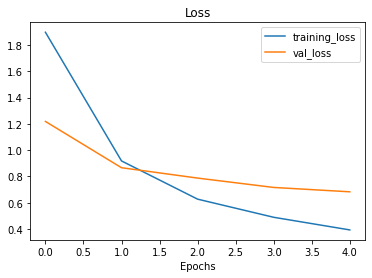

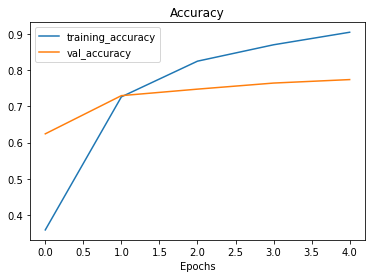

In [14]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [15]:
train_data_10_percent.num_classes

10

In [16]:
#create EfficientNetB0 feature extractor model
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

#compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])


In [17]:
#fit the model
EPOCHS=5

efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="EfficientNetB0")])


Saving TensorBoard log files to : tensorflow_hub/EfficientNetB0/20220219=090343
Epoch 1/5
24/24 [==============================] - 26s 731ms/step - loss: 1.8643 - accuracy: 0.4320 - val_loss: 1.3111 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 15s 643ms/step - loss: 1.0670 - accuracy: 0.7627 - val_loss: 0.8656 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 15s 641ms/step - loss: 0.7538 - accuracy: 0.8427 - val_loss: 0.6946 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 15s 643ms/step - loss: 0.6047 - accuracy: 0.8693 - val_loss: 0.6075 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 644ms/step - loss: 0.5086 - accuracy: 0.8973 - val_loss: 0.5558 - val_accuracy: 0.8616


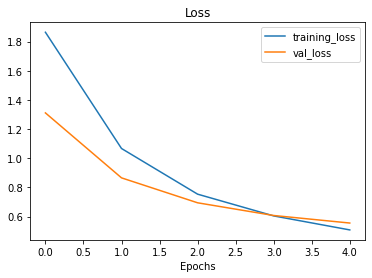

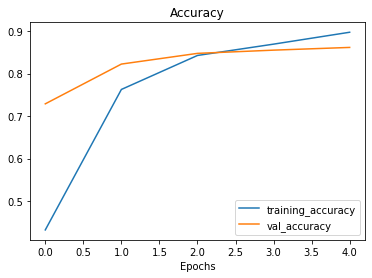

In [19]:
plot_loss_curves(efficientnet_history)

In [22]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* "As is" transfer learning - using an existing model with no change what so ever (using ImageNet model on 1000 ImageNet classes, none of your own)
* "Feature extraction" transfer learnin - use prelearned patterns of an existing model (EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (1000 classes -> 10 classes of food)
* "Fine tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many ir all of the underlying layers (including new output layers).

### Comparing our models' results using tensorboard


In [24]:
#upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architecture using 10% of 10 food classes" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=dRsj8y7TtKfGJvXz2nvBClcZ2YGLSB&prompt=consent&access_type=off

Our tensorboard experimetns are uploaded publically here: https://tensorboard.dev/experiment/JgnIWkSXQoqcKjFEBL5Tqw/#scalars

In [25]:
#check out what tensor board experiment you have
!tensorboard dev list

https://tensorboard.dev/experiment/JgnIWkSXQoqcKjFEBL5Tqw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of 10 food classes
	Id                   JgnIWkSXQoqcKjFEBL5Tqw
	Created              2022-02-19 09:36:56 (4 minutes ago)
	Updated              2022-02-19 09:36:58 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
Total: 1 experiment(s)


In [26]:
#delete an experiment
#!tensorboard dev delete --experiment_id paste_id_here

In [27]:
#confirm the deletion by re-checking what experiment we have
#!tensorboard dev list

## Extra exercise
construct mobilenetV2_model and compare its result with previous models

In [28]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [30]:
mobilenet_model = create_model(model_url=mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

In [35]:
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

mobilenet_history=mobilenet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="MobileNetV2")])

Saving TensorBoard log files to : tensorflow_hub/MobileNetV2/20220219=095912
Epoch 1/5
24/24 [==============================] - 20s 691ms/step - loss: 1.8620 - accuracy: 0.3480 - val_loss: 1.3251 - val_accuracy: 0.5736
Epoch 2/5
24/24 [==============================] - 15s 651ms/step - loss: 1.0110 - accuracy: 0.7080 - val_loss: 0.9079 - val_accuracy: 0.7280
Epoch 3/5
24/24 [==============================] - 15s 655ms/step - loss: 0.7199 - accuracy: 0.8120 - val_loss: 0.7644 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 15s 658ms/step - loss: 0.5696 - accuracy: 0.8560 - val_loss: 0.6858 - val_accuracy: 0.7876
Epoch 5/5
24/24 [==============================] - 15s 651ms/step - loss: 0.4735 - accuracy: 0.8987 - val_loss: 0.6495 - val_accuracy: 0.7948


In [36]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


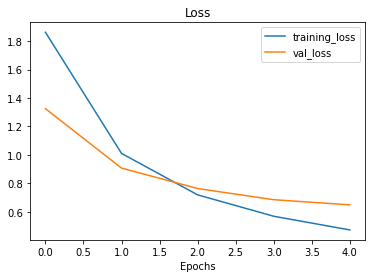

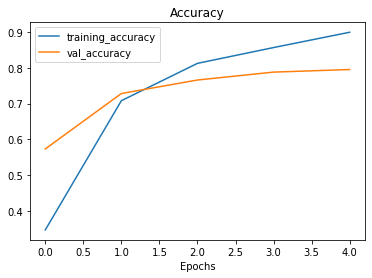

In [37]:
plot_loss_curves(mobilenet_history)